In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler

#Import Model Packages 
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from numpy.linalg import inv, eig, svd

from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA

In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv(r'C:\Users\d34564\Desktop\data.csv',index_col=0,parse_dates=True)

In [4]:
#import yfinance as yf
#data = yf.download(['GLD','SPTL','SPY','UUP'],start='2012-01-01',end='2022-10-31')

In [5]:
#data['Close'].head()

In [6]:
#data = data['Close']

In [7]:
print(data)

                   GLD       SPTL         SPY        UUP
Date                                                    
2012-01-03  155.919998  26.553690  104.071907  21.589964
2012-01-04  156.710007  26.361332  104.235161  21.706245
2012-01-05  157.779999  26.295940  104.512680  21.938812
2012-01-06  157.199997  26.415201  104.243301  22.016336
2012-01-09  156.500000  26.449839  104.496346  21.938812
...                ...        ...         ...        ...
2022-10-24  153.649994  26.972376  378.869995  30.139999
2022-10-25  154.000000  27.680601  384.920013  29.809999
2022-10-26  154.979996  28.039701  382.019989  29.500000
2022-10-27  154.740005  28.328974  379.980011  29.730000
2022-10-28  153.160004  28.119501  389.019989  29.780001

[2725 rows x 4 columns]


In [8]:
import seaborn as sns

<AxesSubplot:>

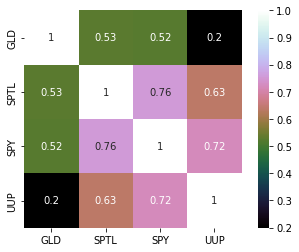

In [9]:
sns.heatmap(data.corr(), vmax=1, square=True,annot=True,cmap='cubehelix')

In [10]:
# Daily Linear Returns (%)
datareturns = data.pct_change(1)

#Remove Outliers beyong 3 standard deviation
datareturns= datareturns[datareturns.apply(lambda x :(x-x.mean()).abs()<(3*x.std()) ).all(1)]

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(datareturns)
rescaledDataset = pd.DataFrame(scaler.fit_transform(datareturns),columns = datareturns.columns, index = datareturns.index)
# summarize transformed data
datareturns.dropna(how='any', inplace=True)
rescaledDataset.dropna(how='any', inplace=True)
rescaledDataset.head(5)

,GLD,SPTL,SPY,UUP
Date,,,,
2012-01-04,0.595394,-0.964307,0.094442,1.325523
2012-01-05,0.808554,-0.332210,0.222412,2.666639
2012-01-06,-0.462821,0.598768,-0.390650,0.859324
2012-01-09,-0.556855,0.170951,0.194918,-0.916338
2012-01-10,1.637219,-0.331252,0.925357,-0.252395


In [12]:
# Dividing the dataset into training and testing sets
percentage = int(len(rescaledDataset) * 0.7)
X_train = rescaledDataset[:percentage]
X_test = rescaledDataset[percentage:]

X_train_raw = datareturns[:percentage]
X_test_raw = datareturns[percentage:]


stock_tickers = rescaledDataset.columns.values
n_tickers = len(stock_tickers)

In [13]:
pca = PCA()
PrincipalComponent=pca.fit(X_train)

,Explained Variance
0,43.20%
1,73.06%
2,87.74%
3,100.00%


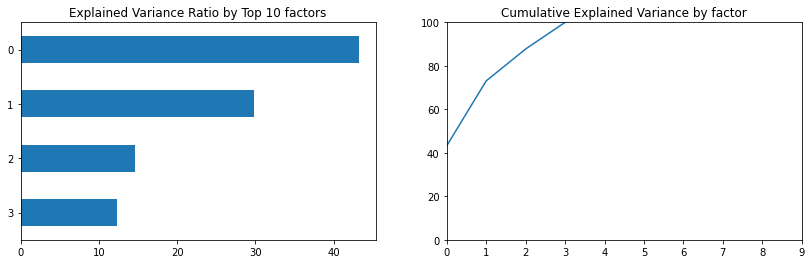

In [14]:
NumEigenvalues=10
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
Series1 = pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]).sort_values()*100
Series2 = pd.Series(pca.explained_variance_ratio_[:NumEigenvalues]).cumsum()*100
Series1.plot.barh(ylim=(0,9), label="woohoo",title='Explained Variance Ratio by Top 10 factors',ax=axes[0]);
Series2.plot(ylim=(0,100),xlim=(0,9),ax=axes[1], title='Cumulative Explained Variance by factor');
# explained_variance
pd.Series(np.cumsum(pca.explained_variance_ratio_)).to_frame('Explained Variance').head(NumEigenvalues).style.format('{:,.2%}'.format)

In [15]:
def PCWeights():
    
    weights = pd.DataFrame()

    for i in range(len(pca.components_)):
        weights["weights_{}".format(i)] = pca.components_[i] / sum(pca.components_[i])

    weights = weights.values.T
    return weights

weights=PCWeights()

In [16]:
weights[0]

array([ 2.7390954 ,  1.5271438 , -0.63382752, -2.63241169])

In [17]:
pca.components_[0]

array([-0.66110559, -0.36859005,  0.15298004,  0.6353565 ])

In [18]:
weights[0]

array([ 2.7390954 ,  1.5271438 , -0.63382752, -2.63241169])

array([[<AxesSubplot:title={'center':'Portfolio 0'}>],
       [<AxesSubplot:title={'center':'Portfolio 1'}>],
       [<AxesSubplot:title={'center':'Portfolio 2'}>],
       [<AxesSubplot:title={'center':'Portfolio 3'}>]], dtype=object)

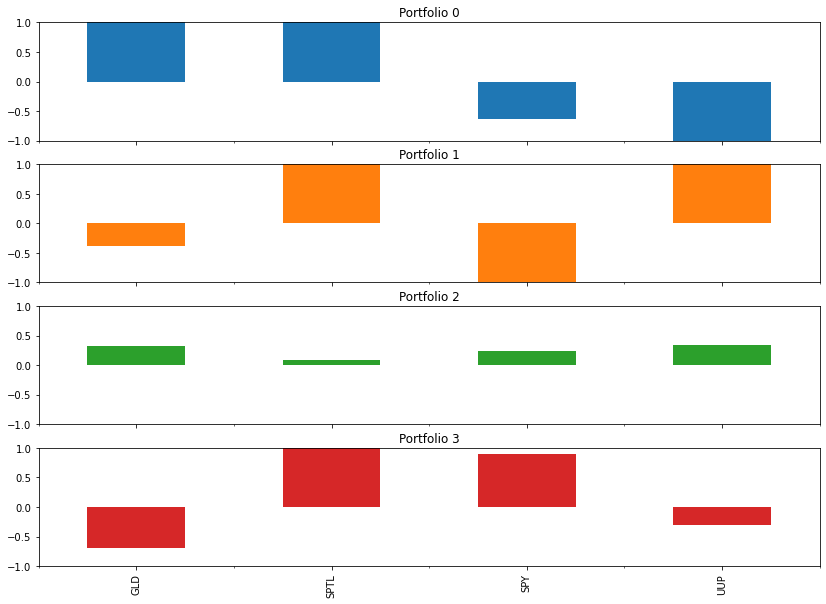

In [19]:
NumComponents=4
        
topPortfolios = pd.DataFrame(pca.components_[:NumComponents], columns=data.columns)
eigen_portfolios = topPortfolios.div(topPortfolios.sum(1), axis=0)
eigen_portfolios.index = [f'Portfolio {i}' for i in range( NumComponents)]
np.sqrt(pca.explained_variance_)
eigen_portfolios.T.plot.bar(subplots=True, layout=(int(NumComponents),1), figsize=(14,10), legend=False, sharey=True, ylim= (-1,1))

In [20]:
# Sharpe Ratio
def sharpe_ratio(ts_returns, periods_per_year=252):
    '''
    Sharpe ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk.
    It calculares the annualized return, annualized volatility, and annualized sharpe ratio.
    
    ts_returns are  returns of a signle eigen portfolio.
    '''
    n_years = ts_returns.shape[0]/periods_per_year
    annualized_return = np.power(np.prod(1+ts_returns),(1/n_years))-1
    annualized_vol = ts_returns.std() * np.sqrt(periods_per_year)
    annualized_sharpe = annualized_return / annualized_vol

    return annualized_return, annualized_vol, annualized_sharpe

Eigen portfolio #2 with the highest Sharpe. Return 6.56%, vol = 4.13%, Sharpe = 1.59
     Return       Vol    Sharpe
2  0.065648  0.041296  1.589697
3  0.154909  0.198732  0.779483
1  0.256333  0.497843  0.514887
0 -0.258260  0.541497 -0.476936


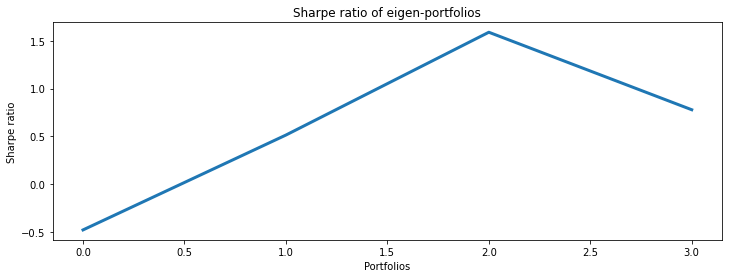

In [21]:
def optimizedPortfolio():
    n_portfolios = len(pca.components_)
    annualized_ret = np.array([0.] * n_portfolios)
    sharpe_metric = np.array([0.] * n_portfolios)
    annualized_vol = np.array([0.] * n_portfolios)
    highest_sharpe = 0 
    stock_tickers = rescaledDataset.columns.values
    n_tickers = len(stock_tickers)
    pcs = pca.components_
    
    for i in range(n_portfolios):
        
        pc_w = pcs[i] / sum(pcs[i])
        eigen_prtfi = pd.DataFrame(data ={'weights': pc_w.squeeze()*100}, index = stock_tickers)
        eigen_prtfi.sort_values(by=['weights'], ascending=False, inplace=True)
        eigen_prti_returns = np.dot(X_train_raw.loc[:, eigen_prtfi.index], pc_w)
        eigen_prti_returns = pd.Series(eigen_prti_returns.squeeze(), index=X_train_raw.index)
        er, vol, sharpe = sharpe_ratio(eigen_prti_returns)
        annualized_ret[i] = er
        annualized_vol[i] = vol
        sharpe_metric[i] = sharpe
        
        sharpe_metric= np.nan_to_num(sharpe_metric)
        
    # find portfolio with the highest Sharpe ratio
    highest_sharpe = np.argmax(sharpe_metric)

    print('Eigen portfolio #%d with the highest Sharpe. Return %.2f%%, vol = %.2f%%, Sharpe = %.2f' % 
          (highest_sharpe,
           annualized_ret[highest_sharpe]*100, 
           annualized_vol[highest_sharpe]*100, 
           sharpe_metric[highest_sharpe]))


    fig, ax = plt.subplots()
    fig.set_size_inches(12, 4)
    ax.plot(sharpe_metric, linewidth=3)
    ax.set_title('Sharpe ratio of eigen-portfolios')
    ax.set_ylabel('Sharpe ratio')
    ax.set_xlabel('Portfolios')

    results = pd.DataFrame(data={'Return': annualized_ret, 'Vol': annualized_vol, 'Sharpe': sharpe_metric})
    results.dropna(inplace=True)
    results.sort_values(by=['Sharpe'], ascending=False, inplace=True)
    print(results.head(20))

    plt.show()

optimizedPortfolio()

Sum of weights of current eigen-portfolio: 100.00


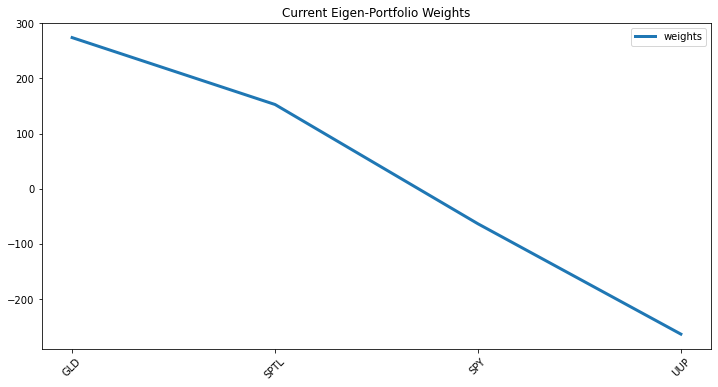

,weights
GLD,273.909540
SPTL,152.714380
SPY,-63.382752
UUP,-263.241169


In [22]:
weights = PCWeights()
portfolio = portfolio = pd.DataFrame()

def plotEigen(weights, plot=False, portfolio=portfolio):
    portfolio = pd.DataFrame(data ={'weights': weights.squeeze()*100}, index = stock_tickers) 
    portfolio.sort_values(by=['weights'], ascending=False, inplace=True)
    if plot:
        print('Sum of weights of current eigen-portfolio: %.2f' % np.sum(portfolio))
        portfolio.plot(title='Current Eigen-Portfolio Weights', 
            figsize=(12,6), 
            xticks=range(0, len(stock_tickers),1), 
            rot=45, 
            linewidth=3
            )
        plt.show()


    return portfolio

# Weights are stored in arrays, where 0 is the first PC's weights.
plotEigen(weights=weights[0], plot=True)

Current Eigen-Portfolio:
Return = 38.59%
Volatility = 22.72%
Sharpe = 1.70


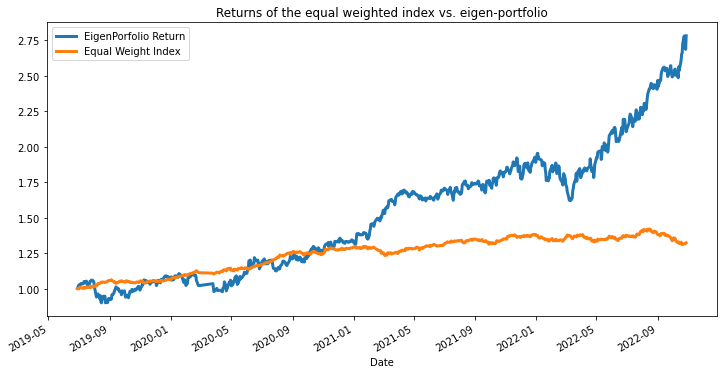

Current Eigen-Portfolio:
Return = -0.33%
Volatility = 50.09%
Sharpe = -0.01


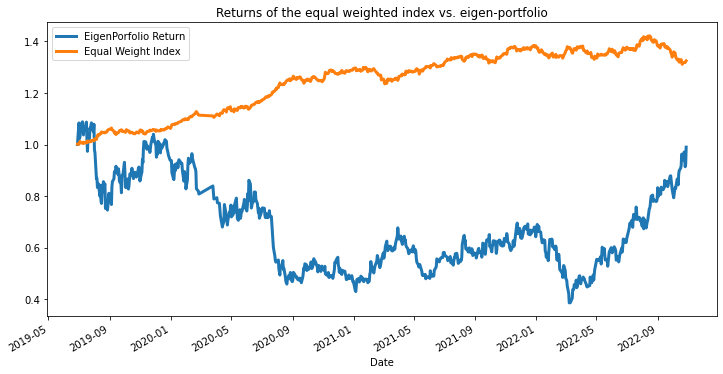

Current Eigen-Portfolio:
Return = -0.33%
Volatility = 50.09%
Sharpe = -0.01


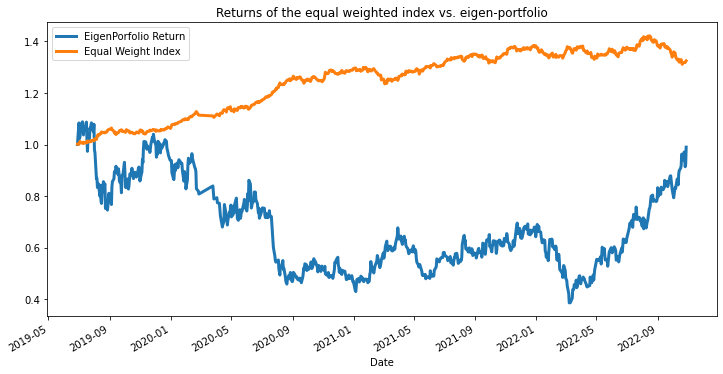

In [23]:
def Backtest(eigen):

    '''

    Plots Principle components returns against real returns.
    
    '''
   
    eigen_prtfi = pd.DataFrame(data ={'weights': eigen.squeeze()}, index = stock_tickers)
    eigen_prtfi.sort_values(by=['weights'], ascending=False, inplace=True)    

    eigen_prti_returns = np.dot(X_test_raw.loc[:, eigen_prtfi.index], eigen)
    eigen_portfolio_returns = pd.Series(eigen_prti_returns.squeeze(), index=X_test_raw.index)
    returns, vol, sharpe = sharpe_ratio(eigen_portfolio_returns)  
    print('Current Eigen-Portfolio:\nReturn = %.2f%%\nVolatility = %.2f%%\nSharpe = %.2f' % (returns*100, vol*100, sharpe))
    equal_weight_return=(X_test_raw * (1/len(pca.components_))).sum(axis=1)    
    df_plot = pd.DataFrame({'EigenPorfolio Return': eigen_portfolio_returns, 'Equal Weight Index': equal_weight_return}, index=X_test.index)
    np.cumprod(df_plot + 1).plot(title='Returns of the equal weighted index vs. eigen-portfolio' , 
                          figsize=(12,6), linewidth=3)
    plt.show()
    
Backtest(eigen=weights[3])
Backtest(eigen=weights[1])
Backtest(eigen=weights[1])

In [24]:
weights[3]

array([-0.68661768,  1.08638938,  0.90148144, -0.30125313])

In [25]:
weights[1]

array([-0.38333557,  2.39324518, -2.63353165,  1.62362204])

In [26]:
weights[0]

array([ 2.7390954 ,  1.5271438 , -0.63382752, -2.63241169])

In [27]:
weights[2]

array([0.32532899, 0.09493642, 0.24517927, 0.33455532])

In [28]:
portfolio = data['GLD']*.27+data['SPTL']*.13+data['SPY']*.26+data['UUP']*.34

<AxesSubplot:title={'center':'Porfolio'}, xlabel='Date', ylabel='price'>

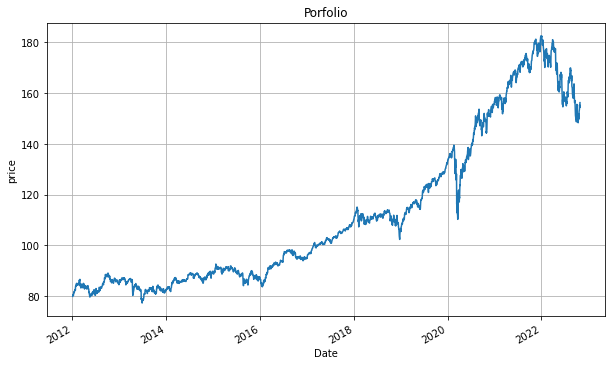

In [29]:
portfolio.plot(figsize=(10,6),grid=True,title='Porfolio',ylabel='price')

In [30]:
portfolio2 = data['GLD']*.25+data['SPTL']*.25+data['SPY']*.25+data['UUP']*.25

<AxesSubplot:title={'center':'Porfolio performance'}, xlabel='Date', ylabel='price'>

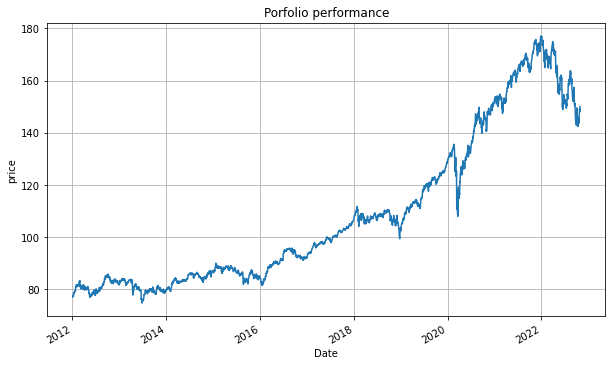

In [31]:
portfolio2.plot(figsize=(10,6),grid=True,title='Porfolio performance',ylabel='price')

In [32]:
backtest = data.pct_change()

In [33]:
backtest['portfolio2'] = sum([backtest['GLD'] * 0.25, backtest['SPTL'] * 0.25, backtest['SPY'] * 0.25, backtest['UUP'] * 0.25])

In [34]:
backtest['portfolio'] = sum([backtest['GLD'] * 0.27, backtest['SPTL'] * 0.13, backtest['SPY'] * 0.26, backtest['UUP'] * 0.34])

In [35]:
backtest['extreme'] = sum([backtest['GLD'] * 0, backtest['SPTL'] * 0, backtest['SPY'] * 0.5, backtest['UUP'] * 0.5])

In [36]:
backtest['extreme2'] = sum([backtest['GLD'] * 0.5, backtest['SPTL'] * 0.5, backtest['SPY'] * 0, backtest['UUP'] * 0])

In [37]:
backtest.dropna()

,GLD,SPTL,SPY,UUP,portfolio2,portfolio,extreme,extreme2
Date,,,,,,,,
2012-01-04,0.005067,-0.007244,0.001569,0.005386,0.001194,0.002665,0.003477,-0.001089
2012-01-05,0.006828,-0.002481,0.002662,0.010714,0.004431,0.005856,0.006688,0.002174
2012-01-06,-0.003676,0.004535,-0.002577,0.003534,0.000454,0.000128,0.000478,0.000430
2012-01-09,-0.004453,0.001311,0.002427,-0.003521,-0.001059,-0.001598,-0.000547,-0.001571
2012-01-10,0.013674,-0.002473,0.008671,-0.000883,0.004747,0.005325,0.003894,0.005600
...,...,...,...,...,...,...,...,...
2022-10-24,-0.003244,-0.006978,0.012236,0.000996,0.000753,0.001737,0.006616,-0.005111
2022-10-25,0.002278,0.026257,0.015969,-0.010949,0.008389,0.004458,0.002510,0.014268
2022-10-26,0.006364,0.012973,-0.007534,-0.010399,0.000351,-0.002090,-0.008967,0.009668


In [38]:
backtest_rtns = (backtest+1).cumprod() - 1

Text(0.5, 1.0, 'Portfolio compare')

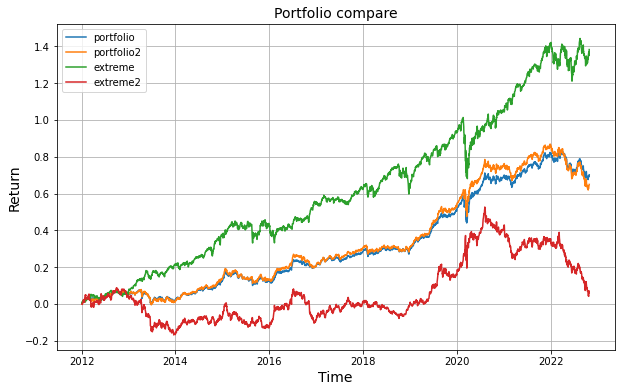

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(backtest_rtns[['portfolio','portfolio2','extreme','extreme2']])
plt.legend(backtest_rtns[['portfolio','portfolio2','extreme','extreme2']])
plt.ylabel('Return',fontsize='14')
plt.xlabel('Time',fontsize='14')
plt.title('Portfolio compare',fontsize='14')

Text(0.5, 1.0, 'Portfolio')

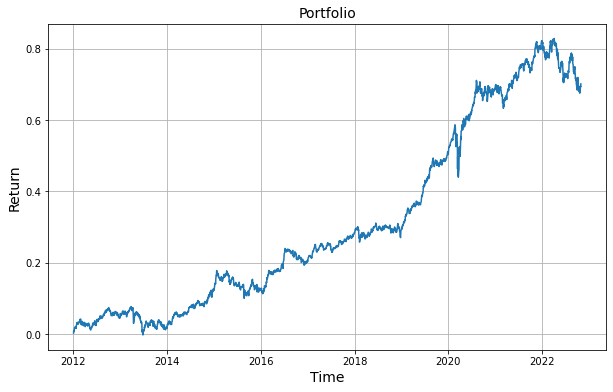

In [40]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(backtest_rtns['portfolio'])

plt.ylabel('Return',fontsize='14')
plt.xlabel('Time',fontsize='14')
plt.title('Portfolio',fontsize='14')

In [41]:
import pyfolio as pf

In [42]:
pf.create_returns_tear_sheet(backtest['portfolio'])

Start date,2012-01-03
End date,2022-10-28
Total months,129
,Backtest
Annual return,5.0%
Cumulative returns,70.2%
Annual volatility,5.8%
Sharpe ratio,0.88
Calmar ratio,0.54
Stability,0.94
Max drawdown,-9.3%


AttributeError: 'numpy.int64' object has no attribute 'to_pydatetime'

In [ ]:
pf.create_returns_tear_sheet(backtest['extreme'])